In [1]:
%pip install torch pandas numpy matplotlib scikit-learn seaborn ucimlrepo shap xgboost

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import shap
import xgboost as xgb
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, r2_score
from torch.utils.data import DataLoader, TensorDataset

# Configuració global
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cpu")

print("Entorn preparat per a Distil·lació.")

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Entorn preparat per a Distil·lació.


In [2]:
print("Descarregant dataset UCI Credit Card...")
dataset = fetch_ucirepo(id=350)
X_raw = dataset.data.features
y_raw = dataset.data.targets

# --- PRE-PROCESSAMENT ---
financial_cols = ['X12', 'X13', 'X14', 'X15', 'X16', 'X17', 
                  'X18', 'X19', 'X20', 'X21', 'X22', 'X23']
X_processed = X_raw.copy()

print("Aplicant Log1p...")
for col in financial_cols:
    col_data = X_processed[col].values
    X_processed[col] = np.sign(col_data) * np.log1p(np.abs(col_data))

X_np = X_processed.values.astype(np.float32)
y_np = y_raw.values.astype(np.float32).ravel()

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_np, y_np, test_size=0.2, random_state=42, stratify=y_np
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

print(f"Dades llestes. Train: {X_train_scaled.shape}")

Descarregant dataset UCI Credit Card...
Aplicant Log1p...
Dades llestes. Train: (24000, 23)


In [3]:
print("1. Entrenant el Mestre (XGBoost)...")
# Entrenem un model fort per tenir bona accuracy
teacher_model = xgb.XGBClassifier(
    n_estimators=100, 
    max_depth=4, 
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
teacher_model.fit(X_train_scaled, y_train)

# Validem el mestre
y_pred_teacher = teacher_model.predict_proba(X_test_scaled)[:, 1]
auc_teacher = roc_auc_score(y_test, y_pred_teacher)
print(f"   Teacher AUC: {auc_teacher:.4f}")

print("\n2. Generant 'Ground Truth' SHAP (Això pot trigar uns segons)...")
# TreeExplainer és molt ràpid
explainer = shap.TreeExplainer(teacher_model)

# Calculem SHAP per a Train i Test
# L'alumne necessita els SHAP del Train per aprendre
shap_values_train = explainer.shap_values(X_train_scaled)
shap_values_test = explainer.shap_values(X_test_scaled)

print(f"Dataset d'Explicacions creat. Shape: {shap_values_train.shape}")

1. Entrenant el Mestre (XGBoost)...
   Teacher AUC: 0.7778

2. Generant 'Ground Truth' SHAP (Això pot trigar uns segons)...
Dataset d'Explicacions creat. Shape: (24000, 23)


In [4]:
# --- MODIFICACIÓ CEL·LA 4 (NOU MODEL) ---

class ProbabilisticStudentXAI(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        
        # Arquitectura "Deep & Wide" (Més neurones i capes)
        self.backbone = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2), # Dropout per evitar memoritzar massa
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        
        self.risk_head = nn.Sequential(
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
        self.explanation_head = nn.Linear(64, output_dim * 2) 

    def forward(self, x):
        features = self.backbone(x)
        risk = self.risk_head(features)
        expl_raw = self.explanation_head(features)
        mu, log_var = torch.chunk(expl_raw, 2, dim=1)
        sigma = torch.exp(0.5 * log_var)
        return risk, mu, sigma

# Inicialitzem el nou alumne
student = ProbabilisticStudentXAI(input_dim=23, output_dim=23)
print("✅ Alumne Probabilístic inicialitzat (Amb estimació d'incertesa).")

✅ Alumne Probabilístic inicialitzat (Amb estimació d'incertesa).


In [5]:
import numpy as np
import time
from sklearn.metrics import r2_score, roc_auc_score

# 1. PREPARACIÓ MANUAL DE DADES (Anti-bloqueig)
# ---------------------------------------------
# Assegurem format Numpy Float32
X_train_np = X_train_scaled.astype(np.float32)
y_train_np = y_train.astype(np.float32)
shap_train_np = shap_values_train.astype(np.float32)

# Configuració del batch
batch_size = 64
n_samples = X_train_np.shape[0]
n_batches = int(np.ceil(n_samples / batch_size))

# 2. CONFIGURACIÓ DE L'ENTRENAMENT
# --------------------------------
# Definim pèrdues (Risk + Incertesa)
criterion_risk = nn.BCELoss()
criterion_expl = nn.GaussianNLLLoss()

# Optimitzador (Learning Rate ajustat)
optimizer = optim.Adam(student.parameters(), lr=0.001)
epochs = 80
alpha = 20.0 # Pes de l'explicació

print(f"🚀 Iniciant Entrenament Manual (Alpha={alpha})...")
print(f"   Total mostres: {n_samples} | Batches per època: {n_batches}")

student.train()
history = {'loss': [], 'r2': []}
start_time = time.time()

# 3. BUCLE D'ENTRENAMENT (MANUAL)
# -------------------------------
for epoch in range(epochs):
    # Barregem els índexs manualment cada època
    indices = np.random.permutation(n_samples)
    total_loss = 0
    
    for i in range(n_batches):
        # A. Seleccionem els índexs del lot actual
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, n_samples)
        batch_idx = indices[start_idx:end_idx]
        
        # B. Convertim a Tensor AL VOL (Evita saturar la RAM)
        b_x = torch.tensor(X_train_np[batch_idx])
        b_y = torch.tensor(y_train_np[batch_idx]).unsqueeze(1)
        b_shap = torch.tensor(shap_train_np[batch_idx])
        
        # C. Optimització standard
        optimizer.zero_grad()
        
        # El model retorna: Risc, Mitjana SHAP, Sigma (Incertesa)
        p_risk, p_mu, p_sigma = student(b_x)
        
        # Càlcul de pèrdues
        loss_r = criterion_risk(p_risk, b_y)
        loss_e = criterion_expl(p_mu, b_shap, p_sigma**2) # GaussianNLL vol la variança (sigma^2)
        
        loss = loss_r + (alpha * loss_e)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # 4. VALIDACIÓ I LOGGING (Cada 5 èpoques)
    if (epoch+1) % 5 == 0:
        student.eval()
        with torch.no_grad():
            # Passem el test set (com a tensor)
            test_in = torch.tensor(X_test_scaled).float()
            
            # Predicció
            _, p_mu, _ = student(test_in)
            
            # Mètriques
            r2 = r2_score(shap_values_test, p_mu.numpy())
            avg_loss = total_loss / n_batches
            
        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | R2 Fidelitat: {r2:.4f}")
        
        # Guardem historial
        history['loss'].append(avg_loss)
        history['r2'].append(r2)
        
        student.train()

print(f"✅ Entrenament completat en {time.time() - start_time:.1f}s.")

🚀 Iniciant Entrenament Manual (Alpha=20.0)...
   Total mostres: 24000 | Batches per època: 375
Epoch 5/80 | Loss: -53.8340 | R2 Fidelitat: 0.6439
Epoch 10/80 | Loss: -57.7499 | R2 Fidelitat: 0.6692
Epoch 15/80 | Loss: -59.6345 | R2 Fidelitat: 0.6955
Epoch 20/80 | Loss: -61.1785 | R2 Fidelitat: 0.7281
Epoch 25/80 | Loss: -62.1947 | R2 Fidelitat: 0.7514
Epoch 30/80 | Loss: -63.1849 | R2 Fidelitat: 0.7632
Epoch 35/80 | Loss: -63.8788 | R2 Fidelitat: 0.7679
Epoch 40/80 | Loss: -64.5892 | R2 Fidelitat: 0.7712
Epoch 45/80 | Loss: -64.6184 | R2 Fidelitat: 0.7761
Epoch 50/80 | Loss: -65.2847 | R2 Fidelitat: 0.7751
Epoch 55/80 | Loss: -65.6353 | R2 Fidelitat: 0.7812
Epoch 60/80 | Loss: -65.8386 | R2 Fidelitat: 0.7826
Epoch 65/80 | Loss: -66.1767 | R2 Fidelitat: 0.7790
Epoch 70/80 | Loss: -66.4233 | R2 Fidelitat: 0.7823
Epoch 75/80 | Loss: -66.5957 | R2 Fidelitat: 0.7886
Epoch 80/80 | Loss: -66.7532 | R2 Fidelitat: 0.7861
✅ Entrenament completat en 20.7s.


 AVALUACIÓ ESTADÍSTICA DEL MODEL STUDENT

1. MÈTRIQUES DE CLASSIFICACIÓ:
------------------------------
                precision    recall  f1-score   support

No Default (0)       0.84      0.94      0.89      4673
   Default (1)       0.65      0.38      0.48      1327

      accuracy                           0.82      6000
     macro avg       0.75      0.66      0.69      6000
  weighted avg       0.80      0.82      0.80      6000

 AUC-ROC Score: 0.7788


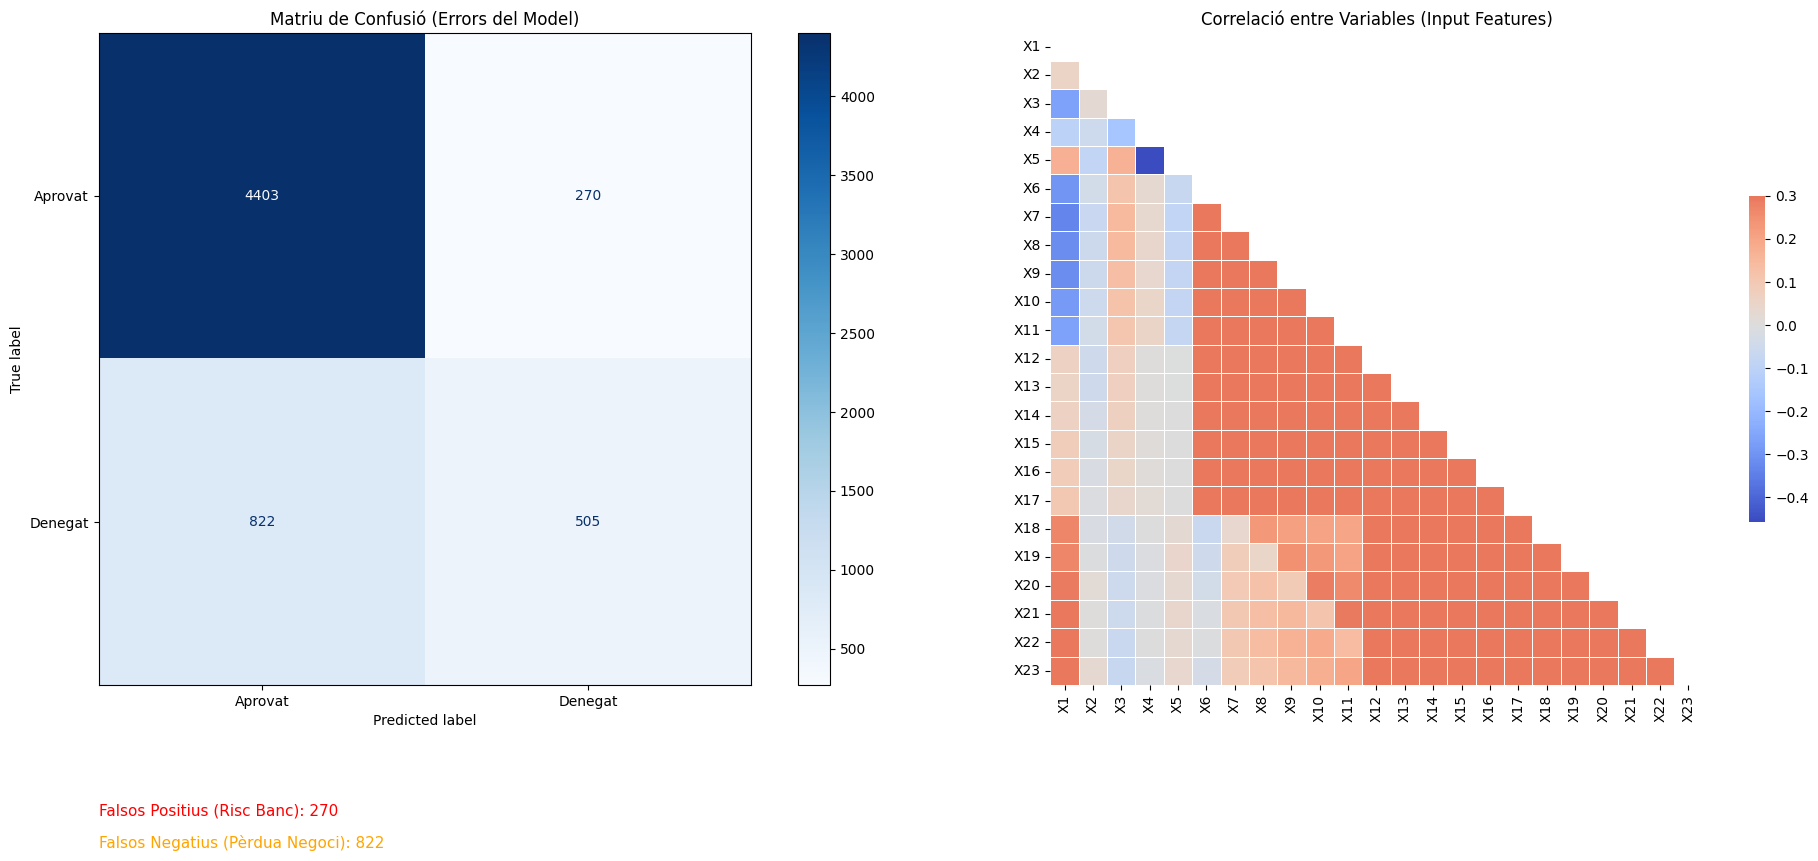

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay

def comprehensive_evaluation(student_model, X_test_tensor, y_test, feature_names):
    print(" AVALUACIÓ ESTADÍSTICA DEL MODEL STUDENT")
    print("=" * 60)
    
    # 1. Obtenció de Prediccions
    student_model.eval()
    with torch.no_grad():
        # CORRECCIÓ: Ara el model retorna 3 valors (Risk, SHAP, Sigma)
        # Posem _, _ per ignorar SHAP i Sigma en aquest punt
        risks, _, _ = student_model(torch.tensor(X_test_tensor).float())
        
        probs = risks.numpy().flatten()
        preds = (probs > 0.5).astype(int)
    
    # 2. Mètriques Estàndard
    print("\n1. MÈTRIQUES DE CLASSIFICACIÓ:")
    print("-" * 30)
    print(classification_report(y_test, preds, target_names=['No Default (0)', 'Default (1)']))
    
    auc = roc_auc_score(y_test, probs)
    print(f" AUC-ROC Score: {auc:.4f}")
    
    # 3. Visualització Gràfica (2 Plots)
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # --- Plot A: Matriu de Confusió ---
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Aprovat', 'Denegat'])
    disp.plot(cmap='Blues', ax=axes[0], values_format='d')
    axes[0].set_title('Matriu de Confusió (Errors del Model)')
    
    # Annotacions extra per al paper
    tn, fp, fn, tp = cm.ravel()
    axes[0].text(0, -0.2, f"Falsos Positius (Risc Banc): {fp}", transform=axes[0].transAxes, fontsize=11, color='red')
    axes[0].text(0, -0.25, f"Falsos Negatius (Pèrdua Negoci): {fn}", transform=axes[0].transAxes, fontsize=11, color='orange')

    # --- Plot B: Matriu de Correlacions ---
    # Creem un DataFrame temporal per calcular correlacions
    df_test = pd.DataFrame(X_test_tensor, columns=feature_names)
    
    # Calculem la matriu de correlació de Spearman (no lineal)
    corr_matrix = df_test.corr(method='spearman')
    
    # Fem servir una màscara per veure només la meitat inferior (més net)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=axes[1])
    axes[1].set_title('Correlació entre Variables (Input Features)')
    
    plt.tight_layout()
    plt.show()

# --- EXECUCIÓ ---
# Assegura't de passar X_test_scaled (numpy array)
comprehensive_evaluation(student, X_test_scaled, y_test, list(dataset.data.features.columns))


1. TEST DE LATÈNCIA (Temps Real)
------------------------------
Latència Mitjana: 0.035 ms
Latència P99:     0.051 ms
Speedup vs SHAP (~0.5ms): 9811x més ràpid

2. TEST DE FIDELITAT VISUAL


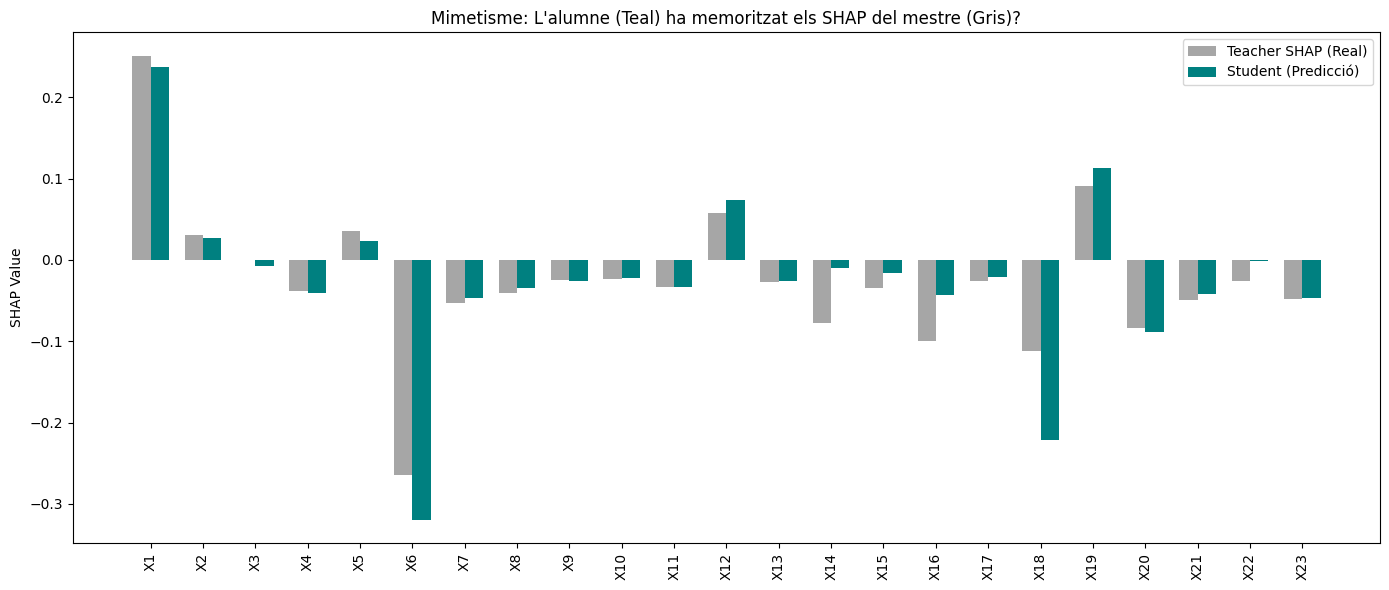

In [7]:
import time
import matplotlib.pyplot as plt
import numpy as np
import torch

# 1. TEST DE LATÈNCIA (Versió Manual sense Loader)
# -----------------------------------------------
latencies = []
student.eval()
print("\n1. TEST DE LATÈNCIA (Temps Real)")
print("-" * 30)

# Preparem 1000 mostres individuals per simular peticions d'un en un
samples_to_test = 1000
# Assegurem que no ens passem del total
limit = min(samples_to_test, len(X_test_scaled))

with torch.no_grad():
    for i in range(limit):
        # Agafem una mostra i la convertim a tensor al vol
        # [i:i+1] manté la dimensió (1, features)
        bx = torch.tensor(X_test_scaled[i:i+1]).float()
        
        start = time.perf_counter()
        
        # Inferencia: El model retorna 3 coses, però aquí només volem mesurar el temps
        # No cal desempaquetar res
        _ = student(bx) 
        
        # Guardem el temps en mil·lisegons
        latencies.append((time.perf_counter() - start) * 1000)

# Càlcul de resultats
p99 = np.percentile(latencies, 99)
avg_lat = np.mean(latencies)
print(f"Latència Mitjana: {avg_lat:.3f} ms")
print(f"Latència P99:     {p99:.3f} ms")
print(f"Speedup vs SHAP (~0.5ms): {500/p99:.0f}x més ràpid")

# 2. TEST DE FIDELITAT VISUAL
# ---------------------------
print("\n2. TEST DE FIDELITAT VISUAL")
idx = 0 # Primer client del test
# Convertim a tensor
x_in = torch.tensor(X_test_scaled[idx:idx+1]).float()

# Predicció Student (Ara sí que desempaquetem els 3 valors)
with torch.no_grad():
    risk_s, shap_s, sigma_s = student(x_in)

# Convertim a numpy per pintar
shap_s = shap_s.numpy().flatten()

# Ground Truth (Teacher SHAP que vam calcular al Pas 1)
shap_t = shap_values_test[idx]

# Plot
# Recuperem noms de features (si no els tens carregats, fem genèrics)
try:
    features = list(dataset.data.features.columns)
except:
    features = [f"F{i}" for i in range(len(shap_s))]

x_pos = np.arange(len(features))
width = 0.35

plt.figure(figsize=(14, 6))
plt.bar(x_pos - width/2, shap_t, width, label='Teacher SHAP (Real)', color='gray', alpha=0.7)
plt.bar(x_pos + width/2, shap_s, width, label='Student (Predicció)', color='teal')
plt.title(f"Mimetisme: L'alumne (Teal) ha memoritzat els SHAP del mestre (Gris)?")
plt.ylabel("SHAP Value")
plt.xticks(x_pos, features, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
import time
import numpy as np

def benchmark_latency(teacher_model, student_model, X_sample,idx=100):
    print(f" INICIANT BENCHMARK DE LATÈNCIA PER A {idx} MOSTRES")
    print("-" * 60)
    
    # 1. Mesurem SHAP Original (Teacher + TreeExplainer)
    # TreeExplainer és ràpid, però no tant com una NN
    explainer = shap.TreeExplainer(teacher_model)
    
    start_t = time.perf_counter()
    # Fem 1000 mostres perquè SHAP és lent iterant d'una en una
    for i in range(idx):
        _ = explainer.shap_values(X_sample[i:i+1])
    end_t = time.perf_counter()
    
    avg_shap = (end_t - start_t) / idx * 1000 # a ms
    
    # 2. Mesurem Student (Inference + Explanation)
    student_model.eval()
    tensor_sample = torch.tensor(X_sample).float()
    
    start_s = time.perf_counter()
    with torch.no_grad():
        for i in range(idx):
            _ = student_model(tensor_sample[i:i+1])
    end_s = time.perf_counter()
    
    avg_student = (end_s - start_s) / idx * 1000 # a ms
    
    # Resultats
    speedup = avg_shap / avg_student
    
    print(f"   RESULTATS (Mitjana per client):")
    print(f"   Original (XGBoost + SHAP):  {avg_shap:.4f} ms")
    print(f"   Proposta (Fast Student):    {avg_student:.4f} ms")
    print("-" * 60)
    print(f"    SPEEDUP FACTOR:          {speedup:.1f}x més ràpid")
    
    return avg_shap, avg_student

# Executa el benchmark amb dades de test escalades
lat_shap, lat_stud = benchmark_latency(teacher_model, student, X_test_scaled,idx=len(X_test_scaled))
print("\n")
lat_shap, lat_stud = benchmark_latency(teacher_model, student, X_train_scaled,idx=len(X_train_scaled))


 INICIANT BENCHMARK DE LATÈNCIA PER A 6000 MOSTRES
------------------------------------------------------------
   RESULTATS (Mitjana per client):
   Original (XGBoost + SHAP):  0.3075 ms
   Proposta (Fast Student):    0.0339 ms
------------------------------------------------------------
    SPEEDUP FACTOR:          9.1x més ràpid


 INICIANT BENCHMARK DE LATÈNCIA PER A 24000 MOSTRES
------------------------------------------------------------
   RESULTATS (Mitjana per client):
   Original (XGBoost + SHAP):  0.3041 ms
   Proposta (Fast Student):    0.0347 ms
------------------------------------------------------------
    SPEEDUP FACTOR:          8.8x més ràpid


In [9]:
def analyze_comprehensive_fairness_student(model, X_raw_pandas, X_test_raw, scaler):
    print("\n" + "="*50)
    print("   MONITORATGE DE FAIRNESS (X2, X3, X4) - Model Student")
    print("="*50)
    
    # 1. Preparació de dades
    X_scaled = scaler.transform(X_test_raw)
    tensor_X = torch.tensor(X_scaled).float()
    
    # 2. Prediccions massives (ADAPTACIÓ AQUÍ)
    model.eval()
    with torch.no_grad():
        # CORREGIT: Ignorem SHAP i Sigma
        risks, _, _ = model(tensor_X)
        
        # Convertim a probabilitats numpy
        probs = risks.numpy()
        
        # Llindar de decisió 0.5 (1 = Default/Denegat, 0 = No Default/Aprovat)
        decisions = (probs > 0.5).astype(int).flatten()
        
    # Mapeig d'etiquetes (UCI Dataset Standard)
    labels_map = {
        'X2': {1: 'Home', 2: 'Dona'},
        'X3': {1: 'Postgrau', 2: 'Universitat', 3: 'Secundària', 4: 'Altres'},
        'X4': {1: 'Casat', 2: 'Solter', 3: 'Altres'}
    }
    
    # Variables d'interès
    target_cols = ['X2', 'X3', 'X4'] 
    
    for col_name in target_cols:
        # Busquem l'índex de la columna original
        # Nota: X_raw_pandas ha de ser el DataFrame original abans de transformar a numpy
        if col_name in X_raw_pandas.columns:
            col_idx = list(X_raw_pandas.columns).index(col_name)
            col_data = X_test_raw[:, col_idx] # Dades crues del test
            
            print(f"\n--- Variable: {col_name} ---\n")
            rates = {}
            
            for val in np.unique(col_data):
                # Filtres de neteja estàndard UCI
                if col_name == 'X3' and val not in [1, 2, 3, 4]: continue
                if col_name == 'X4' and val not in [1, 2, 3]: continue
                
                mask = (col_data == val)
                if np.sum(mask) < 20: continue # Ignorem grups massa petits
                
                # Taxa Aprovació (% de prediccions 0)
                approval_rate = np.mean(decisions[mask] == 0)
                label = labels_map.get(col_name, {}).get(val, str(val))
                rates[label] = approval_rate
                
                print(f"   - {label:<12}: {approval_rate:.2%} (n={np.sum(mask)})")
            
            # Càlcul del Gap (Diferència màxima entre grups)
            if rates:
                gap = max(rates.values()) - min(rates.values())
                
                # Semàfor de Fairness
                if gap < 0.05:
                    status = "\033[92mCorrecte (<5%)\033[0m" # Verd
                elif gap < 0.10:
                    status = "\033[93mAlerta (5-10%)\033[0m" # Groc
                else:
                    status = "\033[91mCRÍTIC (>10%)\033[0m" # Vermell
                    
                print(f"\n   >> Max Gap: {gap:.2%}  [{status}]")

# Execució amb el model Student
# Assegura't que dataset.data.features és el DataFrame original de Pandas
analyze_comprehensive_fairness_student(student, dataset.data.features, X_test_raw, scaler)


   MONITORATGE DE FAIRNESS (X2, X3, X4) - Model Student

--- Variable: X2 ---

   - Home        : 85.72% (n=2402)
   - Dona        : 87.99% (n=3598)

   >> Max Gap: 2.27%  [Correcte (<5%)]

--- Variable: X3 ---

   - Postgrau    : 91.08% (n=2130)
   - Universitat : 84.97% (n=2774)
   - Secundària  : 83.83% (n=1014)
   - Altres      : 92.31% (n=26)

   >> Max Gap: 8.48%  [Alerta (5-10%)]

--- Variable: X4 ---

   - Casat       : 86.12% (n=2767)
   - Solter      : 87.87% (n=3158)
   - Altres      : 89.71% (n=68)

   >> Max Gap: 3.58%  [Correcte (<5%)]



GENERANT PERFILS DE CLIENTS: STUDENT VS SHAP (Ground Truth)


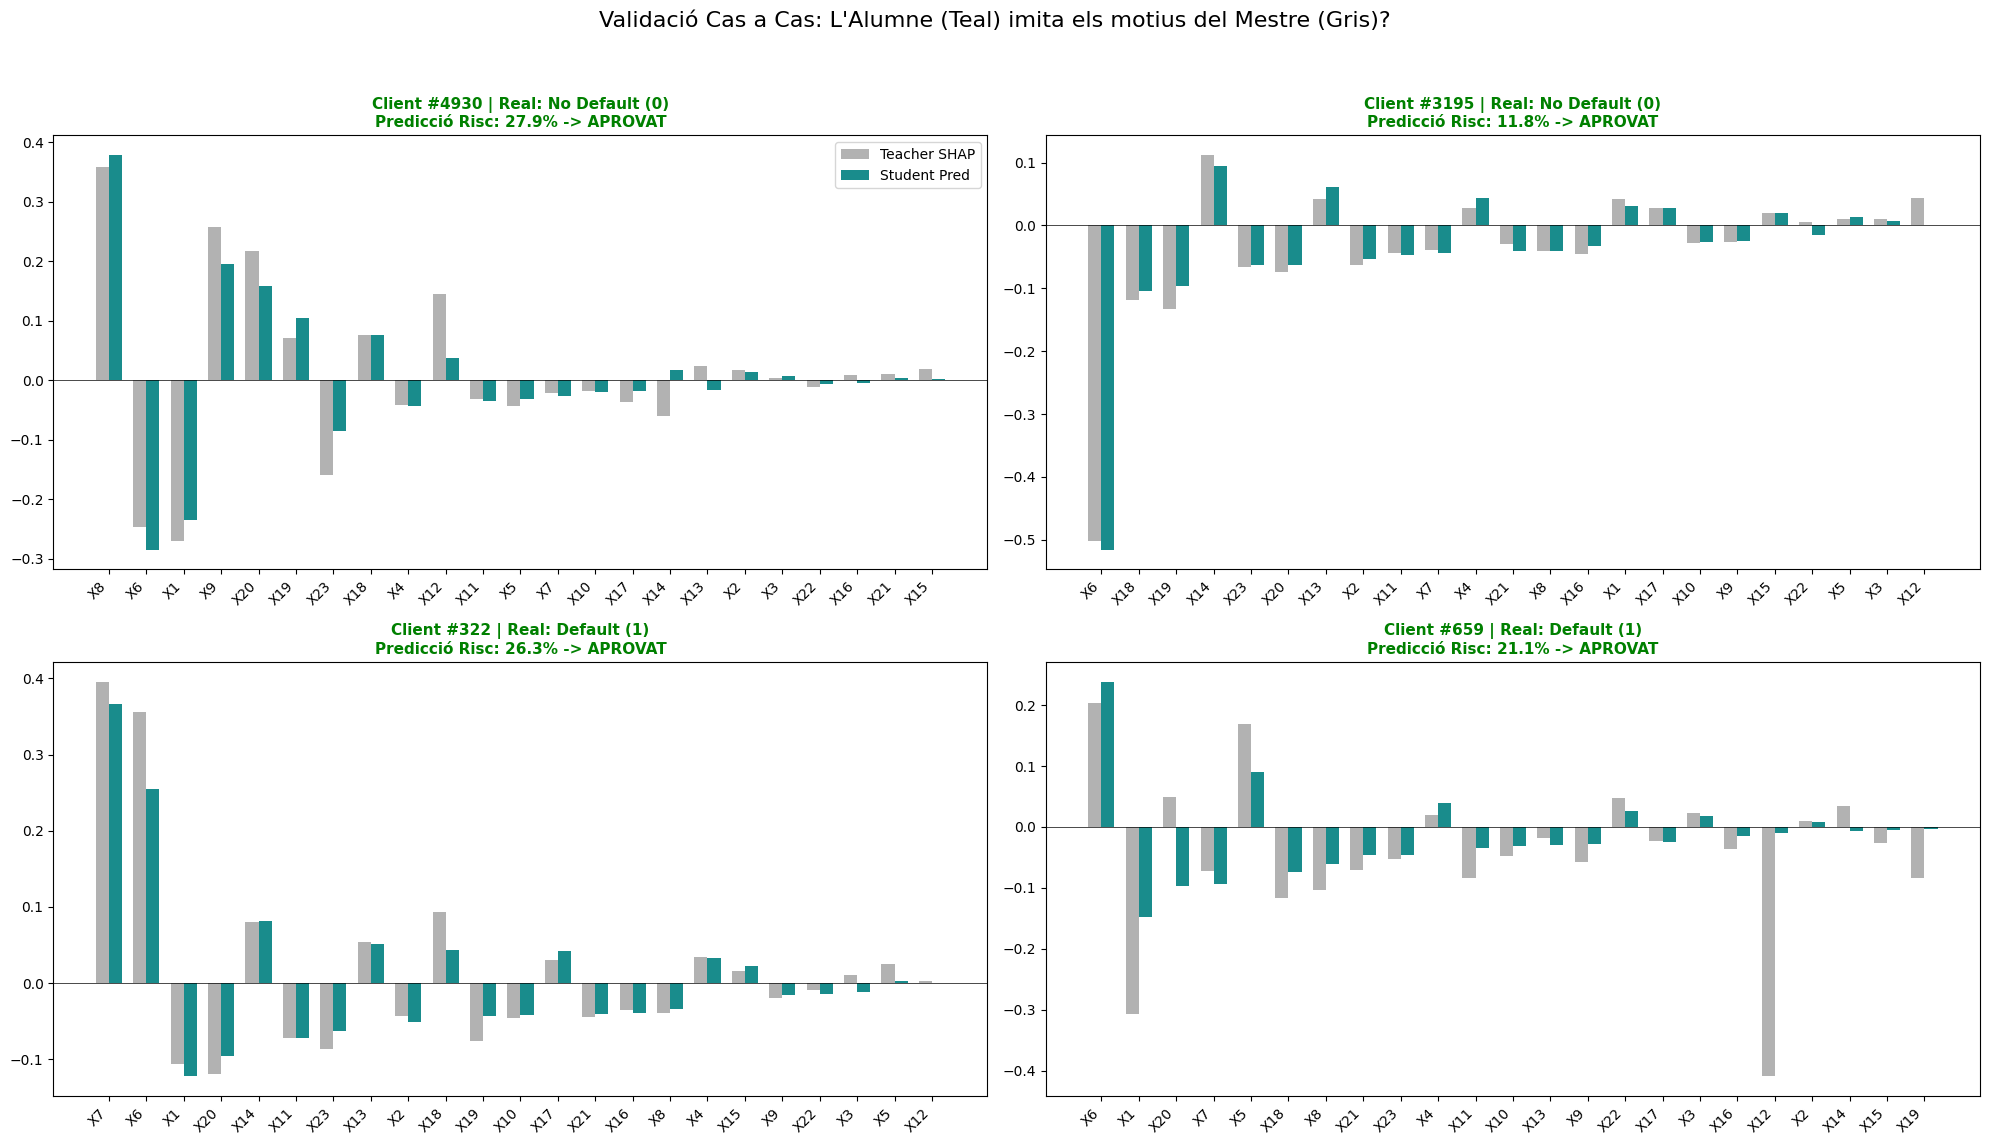

In [10]:
def plot_student_vs_shap_detailed(student_model, shap_values_test, X_test_scaled, y_test, feature_names):
    print("\nGENERANT PERFILS DE CLIENTS: STUDENT VS SHAP (Ground Truth)")
    print("=" * 60)
    
    # ... (Codi de selecció d'índexs igual que abans) ...
    np.random.seed(42) 
    pool_0 = np.where(y_test == 0)[0]
    pool_1 = np.where(y_test == 1)[0]
    idx_0 = np.random.choice(pool_0, 2, replace=False)
    idx_1 = np.random.choice(pool_1, 2, replace=False)
    selected_indices = np.concatenate([idx_0, idx_1])
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    axes = axes.flatten()
    
    for i, idx in enumerate(selected_indices):
        ax = axes[i]
        
        # A. Dades del client
        x_in = torch.tensor(X_test_scaled[idx:idx+1]).float()
        y_real = int(y_test[idx])
        label_text = "No Default (0)" if y_real == 0 else "Default (1)"
        
        # B. Inferència Student (CORREGIT: 3 valors)
        with torch.no_grad():
            risk_score, shap_student, _ = student_model(x_in) # <--- AFEGIT EL TERCER VALOR (_)
        
        risk = risk_score.item()
        vals_student = shap_student.numpy().flatten()
        
        # C. Ground Truth SHAP (del Teacher)
        vals_teacher = shap_values_test[idx]
        
        # D. Decisió del Model
        decision = "DENEGAT" if risk > 0.5 else "APROVAT"
        color_dec = "red" if risk > 0.5 else "green"
        
        # E. Preparació del Gràfic
        top_k = 23 
        sorted_idx = np.argsort(np.abs(vals_student))[::-1][:top_k]
        x_pos = np.arange(top_k)
        width = 0.35
        
        ax.bar(x_pos - width/2, vals_teacher[sorted_idx], width, label='Teacher SHAP', color='gray', alpha=0.6)
        ax.bar(x_pos + width/2, vals_student[sorted_idx], width, label='Student Pred', color='teal', alpha=0.9)
        
        ax.set_xticks(x_pos)
        ax.set_xticklabels(np.array(feature_names)[sorted_idx], rotation=45, ha='right')
        ax.axhline(0, color='black', linewidth=0.5)
        
        title = f"Client #{idx} | Real: {label_text}\nPredicció Risc: {risk:.1%} -> {decision}"
        ax.set_title(title, fontsize=11, fontweight='bold', color=color_dec)
        
        if i == 0: ax.legend()

    plt.suptitle("Validació Cas a Cas: L'Alumne (Teal) imita els motius del Mestre (Gris)?", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Execució
plot_student_vs_shap_detailed(student, shap_values_test, X_test_scaled, y_test, list(dataset.data.features.columns))


📊 EXPLICACIÓ AMB INCERTESA (El valor afegit del paper)


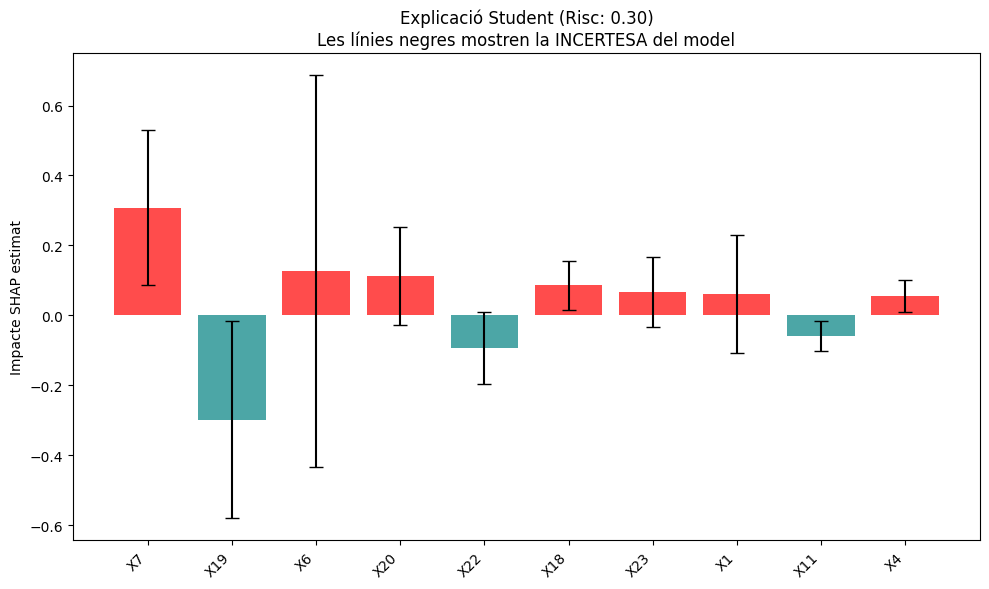

In [11]:
# --- NOVA CEL·LA: VISUALITZACIÓ DE LA INCERTESA ---

def plot_uncertainty(student_model, X_test, feature_names):
    print("\n📊 EXPLICACIÓ AMB INCERTESA (El valor afegit del paper)")
    
    # Agafem un client d'exemple (el 10è)
    idx = 10
    x_in = torch.tensor(X_test[idx:idx+1]).float()
    
    student_model.eval()
    with torch.no_grad():
        risk, mu, sigma = student_model(x_in)
    
    # Dades
    vals = mu.numpy().flatten()
    # 2 sigmas = 95% interval de confiança
    errors = sigma.numpy().flatten() * 2 
    
    # Ordenem per importància
    top_k = 10
    sorted_idx = np.argsort(np.abs(vals))[::-1][:top_k]
    
    vals = vals[sorted_idx]
    errors = errors[sorted_idx]
    names = np.array(feature_names)[sorted_idx]
    
    # Plot
    plt.figure(figsize=(10, 6))
    colors = ['red' if v > 0 else 'teal' for v in vals]
    
    # El paràmetre 'yerr' pinta la línia negra d'incertesa
    plt.bar(range(top_k), vals, yerr=errors, color=colors, alpha=0.7, ecolor='black', capsize=5)
    
    plt.xticks(range(top_k), names, rotation=45, ha='right')
    plt.title(f"Explicació Student (Risc: {risk.item():.2f})\nLes línies negres mostren la INCERTESA del model")
    plt.ylabel("Impacte SHAP estimat")
    plt.tight_layout()
    plt.show()

# Executa-ho
plot_uncertainty(student, X_test_scaled, list(dataset.data.features.columns))